# VLabs Data Challenge 2021 Solution
by Guilherme Levi (https://www.kaggle.com/guilhermelevi)

Welcome! 

I'm proud to present to you my first machine learning implementation to solve a real problem. This notebook is one of the deliverables that made up the final score. Although some decisions are wrong, I will leave comments about possible improvements. Although some decisions are erroneous, as this is my first experience, I will leave comments on points that I believe can be improved.

- **Kaggle Submission Score**: 275.574 (8th Place)
- **Competition Final Score**: 1st Place

Competition Website: https://www.vlabs.visagio.com/data-challenge

The main challenge was forecasting the LTV of a company's customers in the next 90 days. For this, the event organizers provided a sales record comprehending Jan/2020-Feb/2021 period from an actual retailer company with:

- **ID_VENDA**: Sale ID
- **DT_VENDA**: Date
- **Loja**: Store number
- **QTD_SKU**: Quantity of products
- **VALOR**: Value
- **ID_CLIENTE**: Customer ID
- **CANAL**: Channel


The submissions scores were based on the RMSE metric. 

The present solution performed feature engineering to obtain a cross-sectional approach to the problem. In this way, the 90-days LTV of a given customer is predicted based on its 11 previous month sales history.

This notebook includes:
- Exploratory Data Analysis
- Feature Engineering
- Machine Learning Modeling
- Feature Importance Analysis

# 1. Imports

In [3]:
import pandas as pd
import numpy as np
import base64
import kaggle
import zipfile

import matplotlib.pyplot as plt
import plotly as py
import plotly.offline as pyoff
import plotly.express as px
import plotly.graph_objs as go
import plotnine as pn
import plydata.cat_tools as cat
import seaborn as sns

from datetime import datetime
from plotnine import ggplot, geom_point, aes, theme, element_text
from sklearn.cluster import KMeans
from scipy.stats import zscore
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from skopt import gp_minimize
from IPython.display import HTML

In [143]:
# Kaggle API to extract VLabs-DC.zip
!kaggle competitions download -c VLabs-DC --force

# Unzip files from VLabs-DC.zip
with zipfile.ZipFile('VLabs-DC.zip', 'r') as zip_ref:
    zip_ref.extractall()


  0%|          | 0.00/21.3M [00:00<?, ?B/s]
  5%|4         | 1.00M/21.3M [00:00<00:03, 5.87MB/s]
 14%|#4        | 3.00M/21.3M [00:00<00:01, 10.9MB/s]
 23%|##3       | 5.00M/21.3M [00:00<00:01, 12.8MB/s]
 33%|###2      | 7.00M/21.3M [00:00<00:01, 13.2MB/s]
 42%|####2     | 9.00M/21.3M [00:00<00:00, 14.0MB/s]
 52%|#####1    | 11.0M/21.3M [00:00<00:00, 14.5MB/s]
 61%|######    | 13.0M/21.3M [00:01<00:00, 14.8MB/s]
 70%|#######   | 15.0M/21.3M [00:01<00:00, 15.0MB/s]
 80%|#######9  | 17.0M/21.3M [00:01<00:00, 15.2MB/s]
 89%|########9 | 19.0M/21.3M [00:01<00:00, 15.3MB/s]
 99%|#########8| 21.0M/21.3M [00:01<00:00, 15.3MB/s]
100%|##########| 21.3M/21.3M [00:01<00:00, 12.1MB/s]


# 2. Preprocessing

Preprocessing data to check any:
- Inappropriate types
- Missing values

and also to create:
- Auxiliary data frames
- Features data frame
- Target data frame

In [5]:
raw_data = pd.read_csv('sales_20_21_train.csv')
sample_submission = pd.read_csv('sample_submission.csv')

raw_data.head()

ID_VENDA    DT_VENDA  LOJA  QTD_SKU   VALOR  ID_CLIENTE CANAL
0   1176550  2020-01-02    37        1    9.50      337763   FIS
1  11683461  2020-01-02    15        1    6.64      195687   FIS
2   3326484  2020-01-02    29        5  446.87       56059   FIS
3   7317475  2020-01-02    18        1    6.13      297533   FIS
4   4366938  2020-01-02    23        1   13.17      181284   FIS

In [6]:
# Checking missing values
pd.DataFrame(raw_data).isnull().values.any()

False

In [7]:
# Checking types
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630612 entries, 0 to 1630611
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   ID_VENDA    1630612 non-null  int64  
 1   DT_VENDA    1630612 non-null  object 
 2   LOJA        1630612 non-null  int64  
 3   QTD_SKU     1630612 non-null  int64  
 4   VALOR       1630612 non-null  float64
 5   ID_CLIENTE  1630612 non-null  int64  
 6   CANAL       1630612 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 87.1+ MB


## 2.1 DT_VENDA type

In [8]:
# Changing the DT_VENDA typing from TimeStamp to DateTime
df = raw_data
df = df.assign(DT_VENDA = lambda x: pd.to_datetime(x['DT_VENDA']))

## 2.2 Customer ID DF

In [9]:
# Auxiliary data frame with the clients' IDs.
id_clients_df = pd.DataFrame(df['ID_CLIENTE'].unique())
id_clients_df.columns = ['ID_CLIENTE']
id_clients_df = id_clients_df.sort_values(by='ID_CLIENTE').reset_index(drop=True)

## 2.3 Feature/Target split 

As I said in the introduction, the last 90 days of sales history have been set aside to compute the target value. So:
- df_x_train: 11 months -> Features
- df_y_train: 3 months -> Target

In [10]:
last_sale_date = df['DT_VENDA'].max()
date_cutoff = last_sale_date - pd.to_timedelta(90, unit = 'd')
delta_train = date_cutoff - df['DT_VENDA'].min()

df_x_train = df[df['DT_VENDA'] <= date_cutoff]
df_y_train = df[df['DT_VENDA'] > date_cutoff]

## 2.4 Target

A customer's target is computed as the sum of the 90 last-day sales. 

In [11]:
target_df = df_y_train.groupby('ID_CLIENTE')['VALOR'].sum().reset_index()
target_df.columns = ['ID_CLIENTE', 'VALOR_90d']

target_df.head()

ID_CLIENTE  VALOR_90d
0           0     369.35
1           2     235.81
2           4     557.22
3           9      31.27
4          12     286.92

# 2.5 Preliminary Exploratory Data Analysis

### 2.5.1 Data Distribution

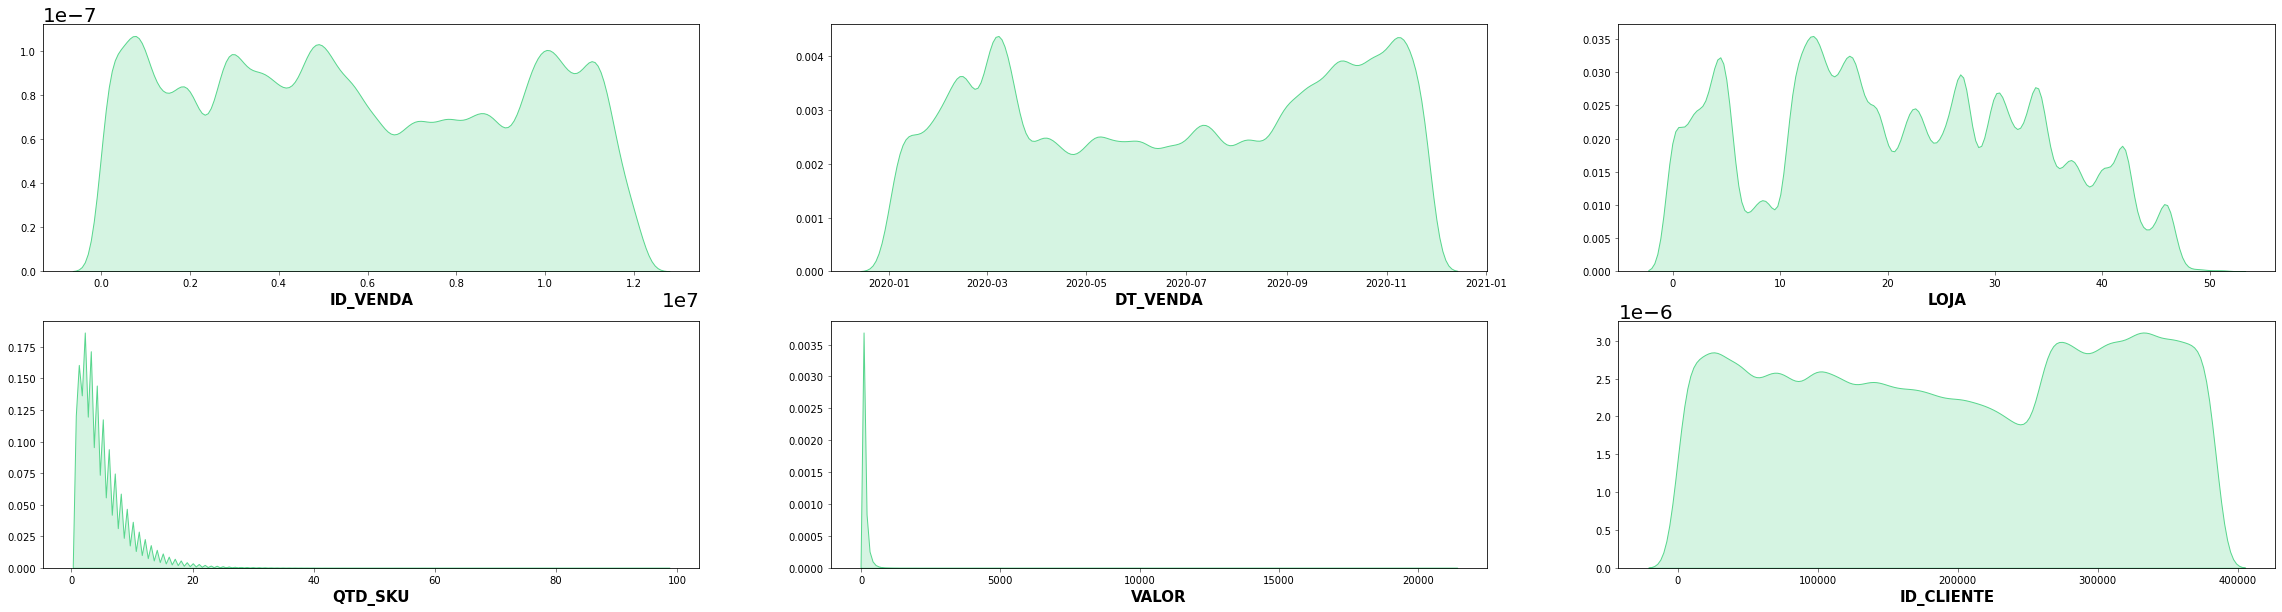

In [38]:
# Features distribution
cont_features=list(df_x_train.columns)
ncols = 3
nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(40,10))

for r in range(nrows):
    for c in range(ncols):
        col = cont_features[r*ncols+c]
        sns.kdeplot(x=df_x_train[col], ax=axes[r, c], fill=True, color='#58D68D')
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=15, fontweight='bold')
        axes[r, c].tick_params(labelsize=10, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(20)
        axes[r, c].yaxis.offsetText.set_fontsize(20)

plt.show()

### 2.5.2 Sales

C:\Users\guilh\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
C:\Users\guilh\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


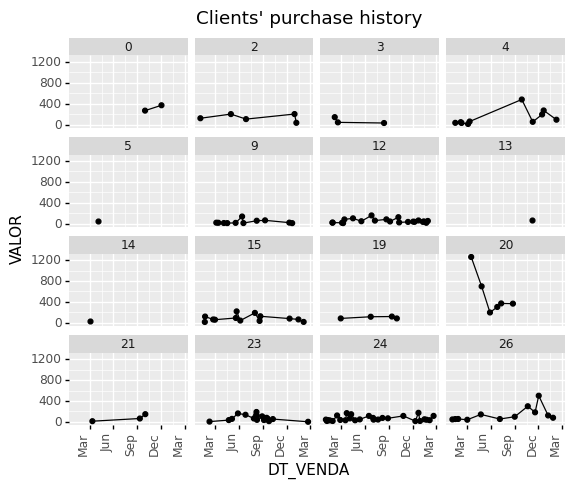

<ggplot: (119601027353)>

In [36]:
# Local sales analysis
plot_df = df.sort_values(by='ID_CLIENTE')

ids = plot_df['ID_CLIENTE'].unique()

ids_selected = ids[0:16]

client_id_subset_df = df[df['ID_CLIENTE'].isin(ids_selected)].groupby(['ID_CLIENTE','DT_VENDA']).sum().reset_index()

pn.ggplot(pn.aes('DT_VENDA', 'VALOR', group = 'ID_CLIENTE'), data = client_id_subset_df) \
    + pn.geom_line()\
    + pn.geom_point()\
    + pn.facet_wrap('ID_CLIENTE')\
    + pn.scale_x_date(date_breaks = '3 months',  date_labels = "%b")\
    + theme(axis_text_x=element_text(rotation=90, hjust=1))\
    + pn.labels.ggtitle("Clients' purchase history")

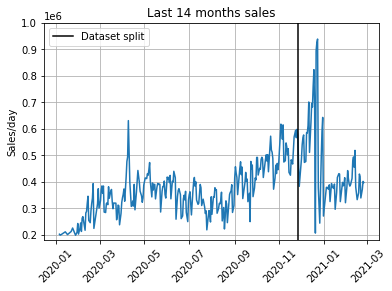

In [39]:
# Global sales analysis
sales = df.groupby('DT_VENDA').VALOR.sum().reset_index()
sales = sales[sales['VALOR'].between(sales['VALOR'].quantile(.20), sales['VALOR'].quantile(1))] 

plt.plot(sales['DT_VENDA'], sales['VALOR'])
plt.xticks(rotation=45)
plt.title('Last 14 months sales')
plt.ylabel('Sales/day')

a = [date_cutoff, date_cutoff]
b = [1e7, -1e7]
plt.plot(a,b,'k',label='Dataset split')
plt.legend()
plt.ylim(180000, 1000000)

plt.grid()
plt.show()

**Local analysis**:
The chart shows very heterogeneous purchase behaviors, which may favor a customer's clustering performance.

**Global analysis**: The last 90 days show unusual behavior, which may bias the model. In this sense, a rolling window approach should perform better.

### 2.5.1 Channel Analysis

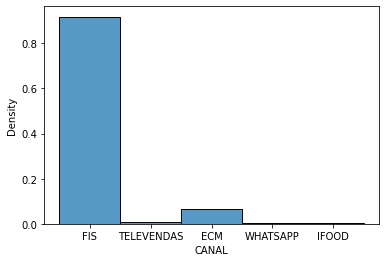

In [114]:
sns.histplot(data = df, x='CANAL', stat='density')
plt.show()

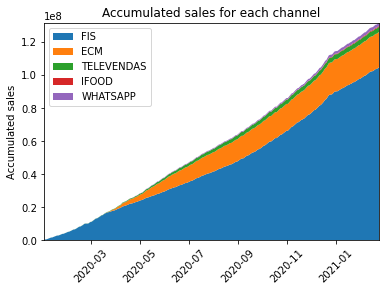

In [40]:
x = pd.DataFrame(df['DT_VENDA'].unique())
x.columns = ['DT_VENDA']
x_datetime = pd.to_datetime(x['DT_VENDA']).apply(lambda x: x.date())
sale_channels = df.groupby(['CANAL','DT_VENDA']).sum().reset_index()

y1 = pd.merge(x,sale_channels[sale_channels['CANAL']=='ECM'], on='DT_VENDA', how ='left').fillna(0)
y2 = pd.merge(x,sale_channels[sale_channels['CANAL']=='FIS'], on='DT_VENDA', how ='left').fillna(0)
y3 = pd.merge(x,sale_channels[sale_channels['CANAL']=='TELEVENDAS'], on='DT_VENDA', how ='left').fillna(0)
y4 = pd.merge(x,sale_channels[sale_channels['CANAL']=='IFOOD'], on='DT_VENDA', how ='left').fillna(0)
y5 = pd.merge(x,sale_channels[sale_channels['CANAL']=='WHATSAPP'], on='DT_VENDA', how ='left').fillna(0)

plt.stackplot(x_datetime,
              y2['VALOR'].cumsum(axis=0),
              y1['VALOR'].cumsum(axis=0),
              y3['VALOR'].cumsum(axis=0),
              y4['VALOR'].cumsum(axis=0),
              y5['VALOR'].cumsum(axis=0),
             labels = ['FIS', 'ECM', 'TELEVENDAS', 'IFOOD', 'WHATSAPP'])
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('Accumulated sales for each channel')
plt.ylabel('Accumulated sales')
plt.show()

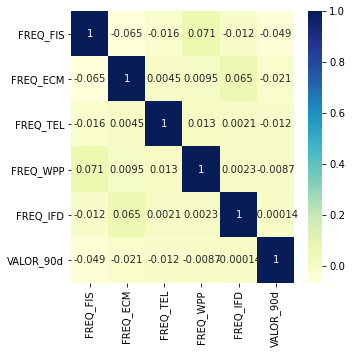

In [115]:
freq_fis_df = df_x_train[df_x_train['CANAL'] == 'FIS'][['ID_CLIENTE','DT_VENDA']].groupby('ID_CLIENTE').count().set_axis(['FREQ_FIS'], axis=1)
freq_ecm_df = df_x_train[df_x_train['CANAL'] == 'ECM'][['ID_CLIENTE','DT_VENDA']].groupby('ID_CLIENTE').count().set_axis(['FREQ_ECM'], axis=1)
freq_tel_df = df_x_train[df_x_train['CANAL'] == 'TELEVENDAS'][['ID_CLIENTE','DT_VENDA']].groupby('ID_CLIENTE').count().set_axis(['FREQ_TEL'], axis=1)
freq_wpp_df = df_x_train[df_x_train['CANAL'] == 'WHATSAPP'][['ID_CLIENTE','DT_VENDA']].groupby('ID_CLIENTE').count().set_axis(['FREQ_WPP'], axis=1)
freq_ifood_df = df_x_train[df_x_train['CANAL'] == 'IFOOD'][['ID_CLIENTE','DT_VENDA']].groupby('ID_CLIENTE').count().set_axis(['FREQ_IFD'], axis=1)

channels_freq = pd.concat([id_clients_df, freq_fis_df, freq_ecm_df, freq_tel_df, freq_wpp_df, freq_ifood_df], axis=1)\
    .merge(
        target_df,
        on='ID_CLIENTE',
        how = 'left'
    )\
    .fillna(0)

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(channels_freq.drop('ID_CLIENTE',axis=1).corr(), cmap="YlGnBu", annot=True)
plt.show()

**Channel Analysis Inferences**:

- The vast majority of sales are made through the FIS channel
- Sales in the ECM channel have grown remarkably in the last 11 months
- There was a low correlation between the frequency of channel use and the amount spent in the following 3 months.

### 3.5.2 QTD_SKU Analysis

In [42]:
QTD_mean_df = df_x_train[['ID_CLIENTE', 'QTD_SKU']].groupby('ID_CLIENTE').mean().set_axis(['QTD_SKU_MEAN'], axis = 1)
QTD_mean_df = pd.merge(id_clients_df, QTD_mean_df , on='ID_CLIENTE')
QTD_mean_target_df = pd.merge( QTD_mean_df, target_df, on='ID_CLIENTE')

In [44]:
QTD_sum_df = df_x_train[['ID_CLIENTE', 'QTD_SKU']].groupby('ID_CLIENTE').sum().set_axis(['QTD_SKU_SUM'], axis = 1)
QTD_sum_df = pd.merge(id_clients_df, QTD_sum_df , on='ID_CLIENTE')
QTD_sum_target_df = pd.merge( QTD_sum_df, target_df, on='ID_CLIENTE')

In [48]:
QTD_target_df = pd.merge(QTD_mean_target_df, QTD_sum_target_df, on=['ID_CLIENTE','VALOR_90d'])

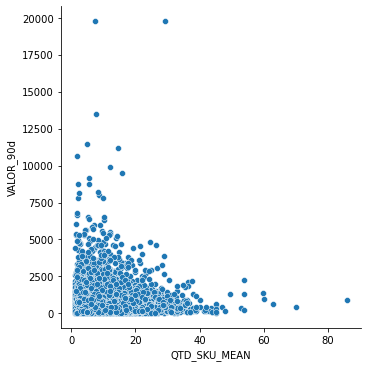

In [51]:
sns.relplot(x="QTD_SKU_MEAN", y="VALOR_90d", data=QTD_mean_target_df);

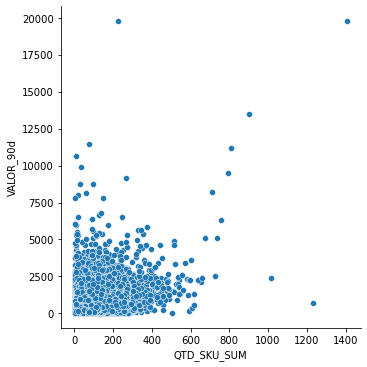

In [52]:
sns.relplot(x="QTD_SKU_SUM", y="VALOR_90d", data=QTD_sum_target_df);

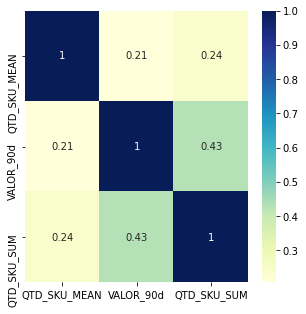

In [49]:
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(QTD_target_df.drop('ID_CLIENTE',axis=1).corr(), cmap="YlGnBu", annot=True)
plt.show()

**QTD_SKU Analysis Inferences**:
- QTD_SKU sum presents better correlation with target than QTD_SKU mean.
- Both features have medium-low correlation with target.

# 3. Feature Engineering

The feature engineering methodology was based on the RFM theory. It's a marketing analysis tool that performs customers' segmentation according to:

- **R**ecency: How recently a customer has made a purchase
- **F**requency: How often a customer makes a purchase
- **M**onetary: How much money a customer spends on purchases

Furthermore, customers were clustered based on these three features and the clusters numeration was used to compute an **Overall Score**, which was again clustered between Low, Medium, and High-value customers.

K-NN algorithm performed the clustering, and the elbow method was applied to select the number of clusters.

## 3.1 Recency

In [12]:
recency_df = df_x_train.groupby('ID_CLIENTE').DT_VENDA.max().reset_index()
recency_df.columns = ['ID_CLIENTE', 'DT_ULTIMA_COMPRA']

# Computes recency
recency_df['RECENCY'] = (recency_df['DT_ULTIMA_COMPRA'].max() - recency_df['DT_ULTIMA_COMPRA']).dt.days

recency_df.head()

ID_CLIENTE DT_ULTIMA_COMPRA  RECENCY
0           0       2020-09-30       57
1           2       2020-06-27      152
2           3       2020-08-13      105
3           4       2020-11-09       17
4           5       2020-04-02      238

In [13]:
R_df = pd.merge(id_clients_df, recency_df[['ID_CLIENTE', 'RECENCY']], on = 'ID_CLIENTE')

### 3.1.1 Recency Clustering

<function matplotlib.pyplot.show(close=None, block=None)>

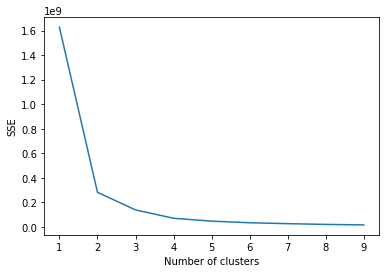

In [14]:
sse = {} # Sum of squared errors
rec_df = R_df[['RECENCY']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters = k,
                   max_iter = 1000).fit(rec_df)
    recency_df['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show

In [15]:
kmeans_recency = KMeans(n_clusters=5)

R_df['RecCluster'] = kmeans_recency.fit_predict(R_df[['RECENCY']])

def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

R_df = order_cluster('RecCluster', 'RECENCY', R_df, False)

In [16]:
R_df.groupby('RecCluster')['RECENCY'].describe()

count        mean        std    min    25%    50%    75%    max
RecCluster                                                                    
0            23216.0  267.943918  22.134094  230.0  254.0  265.0  281.0  329.0
1            19281.0  191.193195  19.363499  157.0  175.0  191.0  205.0  229.0
2            18974.0  121.084115  20.269842   89.0  104.0  120.0  139.0  156.0
3            43922.0   56.162698  15.075498   35.0   43.0   54.0   68.0   88.0
4           104876.0   13.219230   9.706148    0.0    5.0   13.0   21.0   34.0

## 3.2 Frequency

In [17]:
# Computes frequency
frequency_df = df_x_train[['ID_CLIENTE', 'DT_VENDA']].groupby('ID_CLIENTE').count().set_axis(['FREQUENCY'], axis = 1)

RF_df = pd.merge(R_df, frequency_df, on = 'ID_CLIENTE')

RF_df.head()

ID_CLIENTE  RECENCY  RecCluster  FREQUENCY
0           0       57           3          1
1           9       79           3          9
2          19       56           3          4
3          21       56           3          4
4          23       49           3         16

### 3.2.1 Frequence Clustering

<ipython-input-18-6c4b2958c644>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-18-6c4b2958c644>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-18-6c4b2958c644>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-18-6c4b2958c644>

<function matplotlib.pyplot.show(close=None, block=None)>

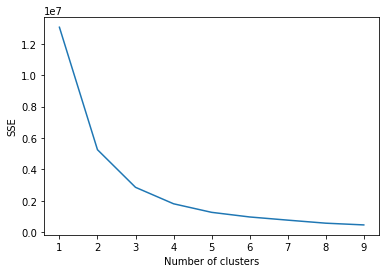

In [18]:
sse = {} # Sum of squared errors
freq_df = RF_df[['FREQUENCY']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters = k,
                   max_iter = 1000).fit(freq_df)
    freq_df['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show

In [19]:
kmeans_freq = KMeans(n_clusters=6)
RF_df['FreqCluster'] = kmeans_freq.fit_predict(RF_df[['FREQUENCY']])

RF_df = order_cluster('FreqCluster', 'FREQUENCY', RF_df, True)

RF_df.groupby('FreqCluster')['FREQUENCY'].describe()

count       mean        std   min   25%   50%   75%    max
FreqCluster                                                               
0            130351.0   1.913464   1.051712   1.0   1.0   2.0   3.0    4.0
1             46497.0   6.952836   1.665815   5.0   5.0   7.0   8.0   10.0
2             23148.0  14.377052   2.748962  11.0  12.0  14.0  16.0   20.0
3              8011.0  26.189614   4.275485  21.0  22.0  25.0  29.0   36.0
4              2021.0  46.431964   8.204741  37.0  40.0  44.0  52.0   68.0
5               241.0  90.419087  28.035593  69.0  74.0  82.0  94.0  299.0

## 3.3 Monetary 

In [20]:
# Computes sum and mean of purchases values
revenue_df = df_x_train.groupby('ID_CLIENTE').aggregate({
    'VALOR' : ['sum', 'mean']
}).set_axis(['PRICE_SUM', 'PRICE_MEAN'], axis = 1)

RFM_df = pd.merge(RF_df, revenue_df, on = 'ID_CLIENTE')

revenue_df.head()

PRICE_SUM  PRICE_MEAN
ID_CLIENTE                       
0              266.94  266.940000
2              426.45  106.612500
3              215.06   71.686667
4              714.65  102.092857
5               47.19   47.190000

## 3.3.1 Monetary Clustering

<ipython-input-21-1f6f6c39d047>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-21-1f6f6c39d047>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-21-1f6f6c39d047>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-21-1f6f6c39d047>

<function matplotlib.pyplot.show(close=None, block=None)>

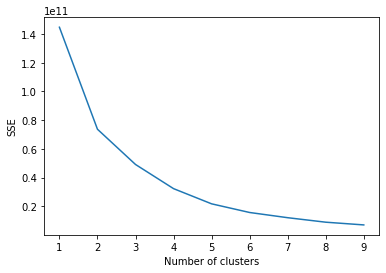

In [21]:
sse = {} # Sum of squared errors
rev_df = RFM_df[['PRICE_SUM']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters = k,
                   max_iter = 1000).fit(rev_df)
    rev_df['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show

In [22]:
kmeans_rev = KMeans(n_clusters=6)

RFM_df['RevCluster'] = kmeans_rev.fit_predict(RFM_df[['PRICE_SUM']])

RFM_df = order_cluster('RevCluster', 'PRICE_SUM', RFM_df, True)

RFM_df.groupby('RevCluster')['PRICE_SUM'].describe()

count          mean           std       min        25%  \
RevCluster                                                              
0           155450.0    165.070538    128.832624      0.05     59.280   
1            39779.0    823.851392    250.068899    495.40    610.210   
2            12125.0   1997.870329    452.885031   1413.57   1612.200   
3             2629.0   4244.646402    957.962938   3125.74   3471.670   
4              283.0   9889.772191   3948.421899   7083.06   7764.795   
5                3.0  79553.546667  25140.542989  50840.31  70523.925   

                 50%        75%       max  
RevCluster                                 
0             129.46    248.490    495.39  
1             766.62   1002.740   1413.48  
2            1893.56   2308.670   3125.64  
3            3967.85   4765.580   7060.99  
4            8514.79  10392.290  39855.66  
5           90207.54  93910.165  97612.79

## 3.4 Overall Score

In [23]:
RFM_df['SCORE'] = RFM_df['RecCluster'] + RFM_df['FreqCluster'] + RFM_df['RevCluster']

RFM_df.groupby('SCORE')['RECENCY', 'FREQUENCY', 'PRICE_SUM'].mean()

<ipython-input-23-d539467cbc7f>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


RECENCY   FREQUENCY     PRICE_SUM
SCORE                                      
0      268.726680    1.464569     88.074969
1      197.478758    1.839279    175.477920
2      134.666711    2.441048    228.667760
3       68.609943    2.531434    193.168586
4       24.459382    2.809861    193.466888
5       24.724532    6.730267    451.262742
6       21.064828    9.858727    768.680297
7       16.100039   14.162270   1100.312987
8       13.003464   19.890207   1648.128329
9       10.390426   26.835702   2359.133079
10       8.439933   37.157953   3308.971830
11       6.343523   49.371179   4726.999549
12       5.247253   74.263736   7038.476154
13       3.038462   97.596154  14582.725192
14      28.000000  107.000000  50840.310000

In [24]:
RFM_df['SEGMENT'] = 'Low-Value'
RFM_df.loc[(RFM_df['SCORE']>4),'SEGMENT'] = 'Mid-Value'
RFM_df.loc[(RFM_df['SCORE']>9),'SEGMENT'] = 'High-Value'

# 4. Train dataset

In [25]:
train_set = pd.merge(RFM_df, target_df, on='ID_CLIENTE', how='left').fillna(0).sort_values(by='ID_CLIENTE').reset_index(drop=True)
train_set = train_set[['ID_CLIENTE', 'RECENCY', 'FREQUENCY', 'PRICE_SUM', 'PRICE_MEAN','RecCluster', 'FreqCluster', 'RevCluster','SCORE','SEGMENT','VALOR_90d']]

train_set.head()

ID_CLIENTE  RECENCY  FREQUENCY  PRICE_SUM  PRICE_MEAN  RecCluster  \
0           0       57          1     266.94  266.940000           3   
1           2      152          4     426.45  106.612500           2   
2           3      105          3     215.06   71.686667           2   
3           4       17          7     714.65  102.092857           4   
4           5      238          1      47.19   47.190000           0   

   FreqCluster  RevCluster  SCORE    SEGMENT  VALOR_90d  
0            0           0      3  Low-Value     369.35  
1            0           0      2  Low-Value     235.81  
2            0           0      2  Low-Value       0.00  
3            1           1      6  Mid-Value     557.22  
4            0           0      0  Low-Value       0.00

## 4.2  Exploratory Data Analysis

### 4.2.1 Relation between Numerical Features and Target

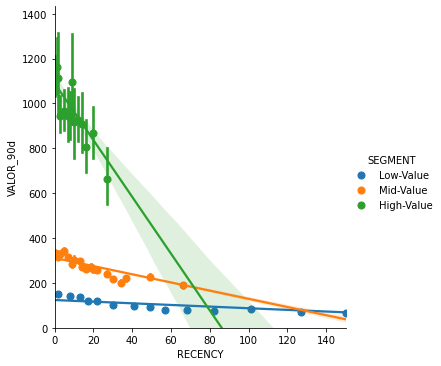

In [287]:
g = sns.lmplot(data=train_set,
               x="RECENCY",
               y="VALOR_90d",
               hue="SEGMENT",
               height=5,
               x_bins = 20)
g.set(xlim=(0, 150))
g.set(ylim=(0, None))

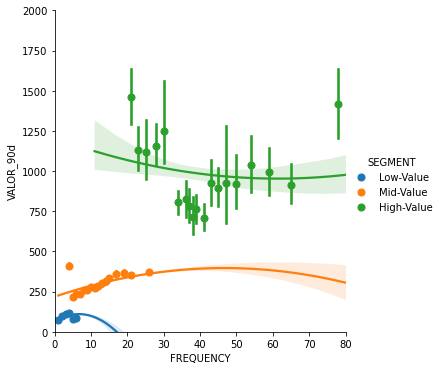

In [154]:
g = sns.lmplot(data=train_set,
               x="FREQUENCY",
               y="VALOR_90d",
               hue="SEGMENT",
               order=2,
               height=5,
               x_bins=20)
g.set(xlim=(0, 80))
g.set(ylim=(0, 2000))

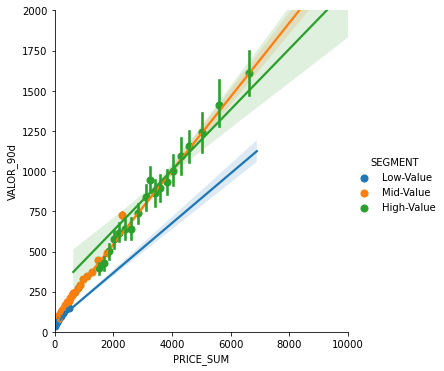

In [289]:
g = sns.lmplot(data=train_set,
               x="PRICE_SUM",
               y="VALOR_90d",
               hue="SEGMENT",
               order = 1,
               height=5,
               x_bins = 20)
g.set(xlim=(0, 10000))
g.set(ylim=(0, 2000))

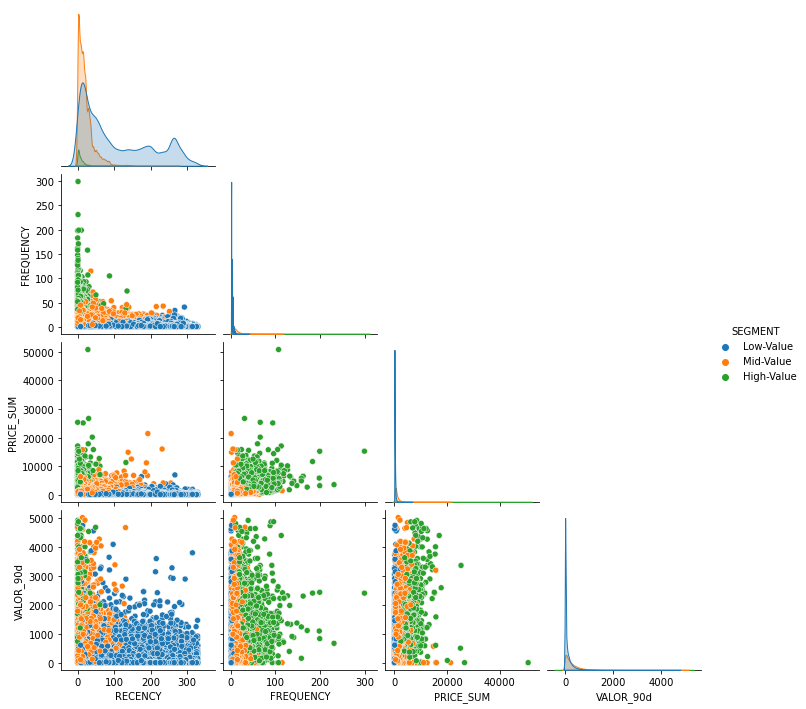

In [140]:
sns.pairplot(filtered_train_set[['RECENCY','FREQUENCY','PRICE_SUM','VALOR_90d','SEGMENT']], corner = True, hue='SEGMENT')

**Inferences**:
- The relations observed between numerical features and target is very promising.
- The clustering seems to fit well
- Features have a right-skewed distribution (may perform better with normalization)

### 4.2.2 Clustering Performance

<AxesSubplot:xlabel='RevCluster', ylabel='VALOR_90d'>

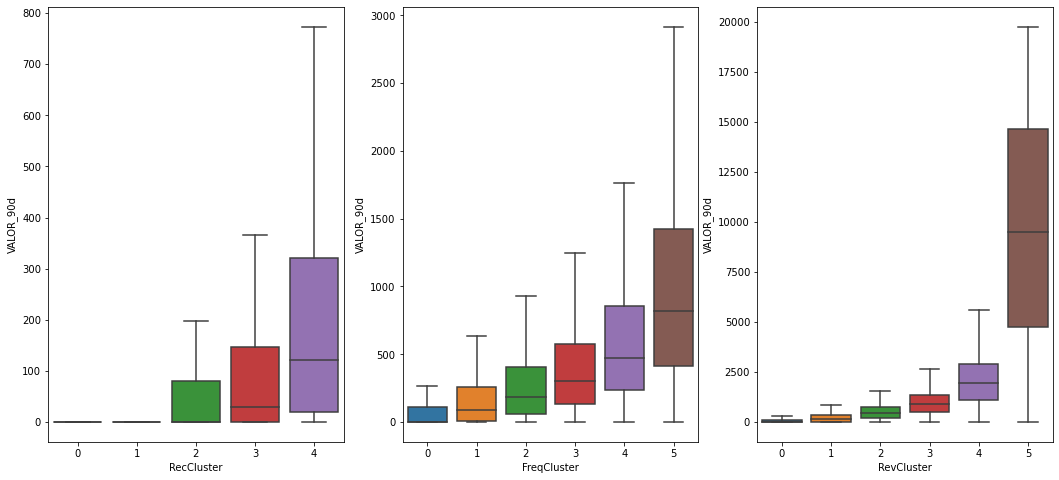

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(18, 8))

# RecCluster
sorted_nb = train_set.groupby(['RecCluster'])['VALOR_90d'].median().sort_values()
sns.boxplot(x=train_set['RecCluster'], y=train_set['VALOR_90d'], order=list(sorted_nb.index), showfliers = False, ax = ax[0])

# FreqCluster
sorted_nb = train_set.groupby(['FreqCluster'])['VALOR_90d'].median().sort_values()
sns.boxplot(x=train_set['FreqCluster'], y=train_set['VALOR_90d'], order=list(sorted_nb.index), showfliers = False, ax = ax[1])

# RevCluster
sorted_nb = train_set.groupby(['RevCluster'])['VALOR_90d'].median().sort_values()
sns.boxplot(x=train_set['RevCluster'], y=train_set['VALOR_90d'], order=list(sorted_nb.index), showfliers = False, ax = ax[2])

<AxesSubplot:xlabel='SCORE', ylabel='VALOR_90d'>

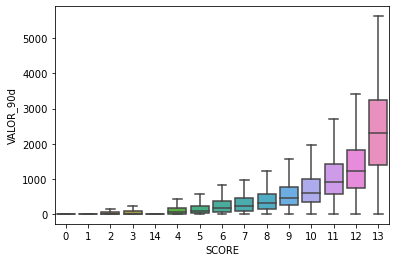

In [82]:
# Score
sorted_nb = train_set.groupby(['SCORE'])['VALOR_90d'].median().sort_values()
sns.boxplot(x=train_set['SCORE'], y=train_set['VALOR_90d'], order=list(sorted_nb.index), showfliers = False)

**Inferences**:
- RFM Clustering seems to perform well
- Clustering Score shows good performance to all scores but 14. This happened because this cluster is sparsely populated. In this sense, all score 14 customers were moved to score 13

<AxesSubplot:xlabel='SCORE', ylabel='VALOR_90d'>

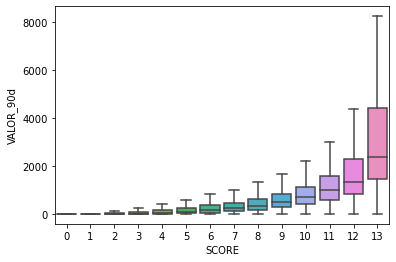

In [26]:
train_set.SCORE = np.where(train_set.SCORE > 13, 13, train_set.SCORE)

# Score
sorted_nb = train_set.groupby(['SCORE'])['VALOR_90d'].median().sort_values()
sns.boxplot(x=train_set['SCORE'], y=train_set['VALOR_90d'], order=list(sorted_nb.index), showfliers = False)

### 4.2.3 Features Correlation

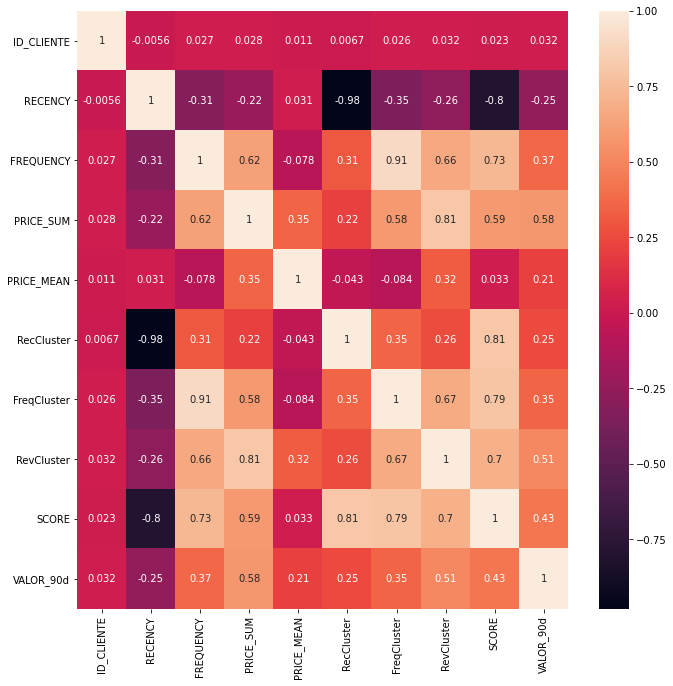

In [27]:
f, ax = plt.subplots(figsize=(11,11))
sns.heatmap(train_set.corr(),annot=True)
plt.show()

**Inferences**:
- Final correlations assumed medium values.
**Improvement Points**:
- Quantile transformation to reduce skewed distribution effects
- Calibrate RFM weights when computing Overall Score
- Calibrate customer segmentation cutoffs

## 4.4 X_train

In [28]:
train_set = pd.get_dummies(train_set)
X_train = train_set.drop(['VALOR_90d', 'ID_CLIENTE'],axis=1)

X_train

RECENCY  FREQUENCY  PRICE_SUM  PRICE_MEAN  RecCluster  FreqCluster  \
0            57          1     266.94  266.940000           3            0   
1           152          4     426.45  106.612500           2            0   
2           105          3     215.06   71.686667           2            0   
3            17          7     714.65  102.092857           4            1   
4           238          1      47.19   47.190000           0            0   
...         ...        ...        ...         ...         ...          ...   
210264       40          5     605.00  121.000000           3            1   
210265        9          1      35.56   35.560000           4            0   
210266       10         15    1210.72   80.714667           4            2   
210267        8         15     492.72   32.848000           4            2   
210268        8          1     131.67  131.670000           4            0   

        RevCluster  SCORE  SEGMENT_High-Value  SEGMENT_Low-Value  \
0                0      3                   0                  1   
1                0      2                   0                  1   
2                0      2                   0                  1   
3                1      6                   0                  0   
4                0      0                   0                  1   
...            ...    ...                 ...                ...   
210264           1      5                   0                  0   
210265           0      4                   0                  1   
210266           1      7                   0                  0   
210267           0      6                   0                  0   
210268           0      4                   0                  1   

        SEGMENT_Mid-Value  
0                       0  
1                       0  
2                       0  
3                       1  
4                       0  
...                   ...  
210264                  1  
210265                  0  
210266                  1  
210267                  1  
210268                  0  

[210269 rows x 11 columns]

## 4.5 y_train

In [29]:
y_train = train_set['VALOR_90d']
y_train

0         369.35
1         235.81
2           0.00
3         557.22
4           0.00
           ...  
210264    122.80
210265      0.00
210266     61.72
210267    102.77
210268    605.65
Name: VALOR_90d, Length: 210269, dtype: float64

# 5. Machine Learning

## 5.1 Regressor Model

**Decision Trees**: It's a machine learning algorithm that divides data based on features values. (More details: https://www.kaggle.com/dansbecker/how-models-work)

<img src="dtrees.jpg" width ="400" height=500 >

**Gradient boosting**: It's a method that goes through cycles to iteratively add models into an ensemble. (More details: https://www.kaggle.com/alexisbcook/xgboost)

<img src="gradboost.jpg" width ="550" >

### 5.1.1 Tunning

I chose GridSearchCV tunning method to develop a better understanding of the behavior of each hyperparameter, although this is not the most efficient method.

In [151]:
# xgb_tune = XGBRegressor(objective = 'reg:squarederror', random_state = 5)

# xgb_tune =  GridSearchCV(estimator=xgb_tune,
#                       param_grid = dict(
#                           learning_rate = [0.03, 0.04, 0.05, 0.06, 0.07],
# #                           num_leaves = [2, 64, 128],
# #                           sub_samples = [0.6, 0.8, 1],
#                           colsample_bytree = [0.7, 0.8, 0.9],
#                           max_depth = [4, 5, 6],
#                           n_estimators = [90,100,110,120]
#                       ),
#                        scoring = 'neg_root_mean_squared_error',
#                        refit = True,
#                        cv = 3,
#                        verbose = 3
#                       )

# xgb_tune.fit(X_train, y_train)

In [152]:
# xgb_tune.best_score_

In [153]:
# xgb_tune.best_params_

In [154]:
# predictions_reg = xgb_tune.predict(X_train)

# predictions_reg

### 5.2 Fitting

In [30]:
xgb_LTV = XGBRegressor(learning_rate=0.05, max_depth = 4, objective = 'reg:squarederror',
                           colsample_bytree = 0.8, random_state=3,
                           n_estimators = 100)
xgb_LTV.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=3,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
p = xgb_LTV.predict(X_train)

pd.DataFrame(p).head()

0
0  135.481216
1   84.692070
2   73.219429
3  280.128021
4   28.951813

### 5.2.1 Train set error

In [32]:
np.sqrt(mean_squared_error(y_train, p))

246.76114529485739

## 5.3 Feature Importance

When computing feature importance, it's common to use methods that can be biased in some data scenarios (https://blog.methodsconsultants.com/posts/be-aware-of-bias-in-rf-variable-importance-metrics/). To avoid bias, I chose two diferent approaches:
- Model importance metric
- SHAP - SHapley Additive exPlanations (https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30)

## 5.3.1 Booster gain

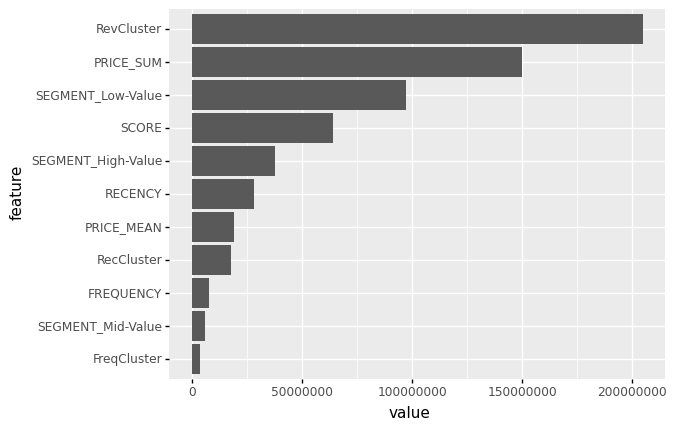

<ggplot: (113548866301)>

In [33]:
imp_spend_amount_dict = xgb_LTV\
    .get_booster()\
    .get_score(importance_type = 'gain')

imp_spend_amount_df = pd.DataFrame(
    data = {
        'feature':list(imp_spend_amount_dict.keys()),
        'value':list(imp_spend_amount_dict.values())
    }
    )\
    .assign(feature = lambda x: cat.cat_reorder(x['feature'], x['value']))


pn.ggplot(pn.aes('feature', 'value'), data=imp_spend_amount_df) + pn.geom_col() + pn.coord_flip()

## 5.3.2 SHAP

In [36]:
train_ = X_train.copy()

from sklearn.model_selection import train_test_split
X_train, X_val, ytrain, yval = train_test_split(train_, y_train, train_size = 0.5)

model = XGBRegressor(learning_rate=0.05, max_depth = 4, objective = 'reg:squarederror',
                           colsample_bytree = 0.8, random_state=3,
                           n_estimators = 100)
model.fit(X_train, ytrain)

In [83]:
# Creates SHAP explainer
import shap
explainer = shap.TreeExplainer(model)

In [111]:
shap_values = explainer.shap_values(X_train, ytrain)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


**Global Analysis**

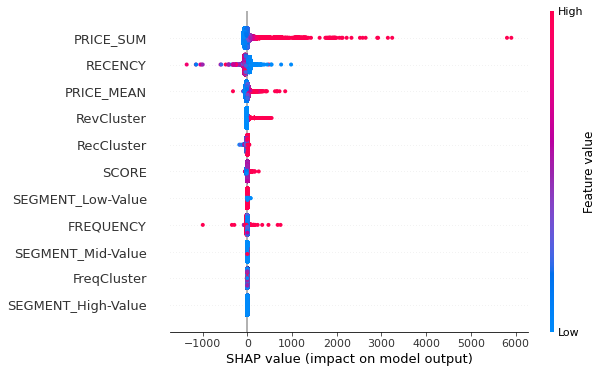

In [112]:
shap.summary_plot(shap_values, X_train, plot_type="dot");

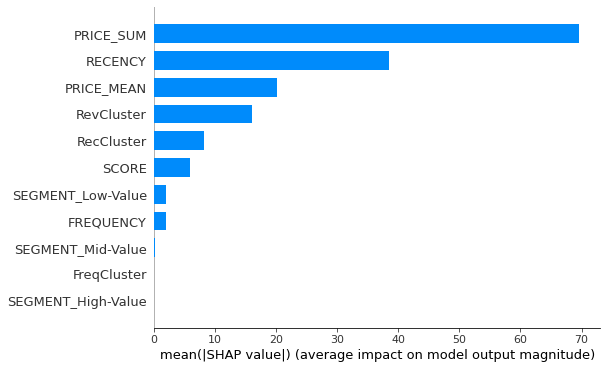

In [113]:
shap.summary_plot(shap_values, X_train, plot_type="bar");

**Local Analysis**

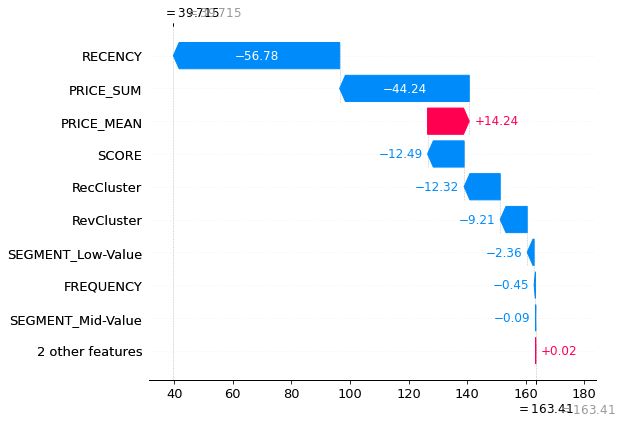

In [115]:
shap.plots._waterfall.waterfall_legacy(expected_value=expected_value,
                                       shap_values=shap_values[1].reshape(-1),
                                       feature_names=X_train.columns, show=True)

**Inferences**:
- Monetary, Recency, and Score features have a significant influence on predictions.
- Frequency and Segment features didn't perform well

# 6. Forecasting

## 6.1 Split last 11 months

In [118]:
fore_cutoff = last_sale_date - pd.to_timedelta(329, unit = 'd')
fore_df = df[df['DT_VENDA'] > fore_cutoff]

## 6.2 Features Computation

### 6.2.1 Recency

In [120]:
fore_recency_df = fore_df.groupby('ID_CLIENTE').DT_VENDA.max().reset_index()
fore_recency_df.columns = ['ID_CLIENTE', 'DT_ULTIMA_COMPRA']

fore_recency_df['RECENCY'] = (fore_recency_df['DT_ULTIMA_COMPRA'].max() - fore_recency_df['DT_ULTIMA_COMPRA']).dt.days
fore_recency_df = fore_recency_df.drop(['DT_ULTIMA_COMPRA'], axis=1)

fore_recency_df = fore_recency_df[fore_recency_df.ID_CLIENTE.isin(sample_submission['ID_CLIENTE'])]

In [121]:
# Customers who are on sample_submission but have not purchased in the last 11 months (will be considered as churn)
outdated = sample_submission[~sample_submission.ID_CLIENTE.isin(fore_recency_df.ID_CLIENTE)].drop('VALOR', axis=1)
outdated['VALOR'] = 0 

### 6.2.2 Frequency

In [122]:
fore_freq_df = fore_df[['ID_CLIENTE', 'DT_VENDA']].groupby('ID_CLIENTE').count().set_axis(['FREQUENCY'], axis = 1)

fore_freq_df = fore_freq_df[fore_freq_df.index.isin(sample_submission['ID_CLIENTE'])]
fore_RFM_df = pd.merge(fore_recency_df, fore_freq_df, on='ID_CLIENTE')

### 6.2.3 Monetary

In [123]:
fore_rev_df = fore_df.groupby('ID_CLIENTE').aggregate({
    'VALOR' : ['sum', 'mean']
}).set_axis(['PRICE_SUM', 'PRICE_MEAN'], axis = 1)

fore_rev_df = fore_rev_df[fore_rev_df.index.isin(sample_submission['ID_CLIENTE'])]

fore_RFM_df = pd.merge(fore_RFM_df, fore_rev_df, on = 'ID_CLIENTE')

### 6.2.4 Clustering

In [124]:
fore_RFM_df['RecCluster'] = kmeans_recency.predict(fore_RFM_df[['RECENCY']])
fore_RFM_df['FreqCluster'] = kmeans_freq.predict(fore_RFM_df[['FREQUENCY']])
fore_RFM_df['RevCluster'] = kmeans_rev.predict(fore_RFM_df[['PRICE_SUM']])

In [125]:
fore_RFM_df = order_cluster('RecCluster', 'RECENCY', fore_RFM_df, False)
fore_RFM_df = order_cluster('FreqCluster', 'FREQUENCY', fore_RFM_df, True)
fore_RFM_df = order_cluster('RevCluster', 'PRICE_SUM', fore_RFM_df, True)

### 6.2.5 Overall Score

In [127]:
fore_RFM_df['SCORE'] = fore_RFM_df['RecCluster'] + fore_RFM_df['FreqCluster'] + fore_RFM_df['RevCluster']

In [128]:
fore_RFM_df['SEGMENT'] = 'Low-Value'
fore_RFM_df.loc[(fore_RFM_df['SCORE']>4),'SEGMENT'] = 'Mid-Value'
fore_RFM_df.loc[(fore_RFM_df['SCORE']>9),'SEGMENT'] = 'High-Value'

fore_RFM_df = fore_RFM_df.sort_values(by='ID_CLIENTE').reset_index(drop=True)

## 6.3 Test set

In [133]:
fore_features_df = fore_RFM_df

In [134]:
X_test_set = pd.get_dummies(fore_features_df).drop('ID_CLIENTE',axis=1)

## 6.4 Test Prediction

In [135]:
predictions = xgb_LTV.predict(X_test_set)

predictions

array([419.45285 , 100.81686 , 279.16974 , ...,  45.802864, 231.31491 ,
       235.8408  ], dtype=float32)

In [138]:
pred_df = pd.DataFrame(predictions)
pred_df.columns = ['VALOR']

pred_df['ID_CLIENTE'] = fore_RFM_df['ID_CLIENTE']
pred_df = pred_df[['ID_CLIENTE','VALOR']]

# 7. Submission preparation

In [140]:
submission_final = pred_df.append(outdated, ignore_index=True)[['ID_CLIENTE','VALOR']].set_index('ID_CLIENTE', drop=True).sort_values(by='ID_CLIENTE')

submission_final.head()

VALOR
ID_CLIENTE            
4           419.452850
9           100.816856
12          279.169739
15          299.321228
19           72.242569

In [142]:
def create_download_link( df, title = "Download CSV file", filename = "submission.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(submission_final)

# Next Steps

- Feature Scaler and Quantile Transformation
- Bayesian Optimization
- Ensemble of XGBoost models
- Implement pipelines
- Manufacture features with greater importance